<a href="https://colab.research.google.com/github/sibyjackgrove/SolarPV-DER-simulation-utility/blob/master/examples/PV-DER_usage_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation and usage

## Installation from repository
Users can download the `SolarPV-DER-simulation-utility` repository and install with `pip`. Note that if the installation is done in a Google Colab environment, the kernel need to be restarted before importing the (otherwise you will get a module import error).

In [1]:
import os
try:
    import pvder
except ImportError:
    !git clone https://github.com/sibyjackgrove/SolarPV-DER-simulation-utility.git
        
    if os.path.exists(os.path.join(os.getcwd(), 'SolarPV-DER-simulation-utility')):
        %cd SolarPV-DER-simulation-utility
        !pip install -e .
        %cd ..

## Basic usage

### Import classes
Import classes neccessary to define instances of the PV-DER model, events, simulation, and results.

In [2]:
#Import PV-DER modules
from pvder.DER_components_single_phase import SolarPV_DER_SinglePhase
from pvder.DER_components_three_phase  import SolarPV_DER_ThreePhase
from pvder.grid_components import Grid
from pvder.dynamic_simulation import DynamicSimulation
from pvder.simulation_events import SimulationEvents
from pvder.simulation_utilities import SimulationUtilities,SimulationResults
from pvder import utility_functions

#Import Python modules
import numpy as np
import scipy as sci
import matplotlib as matplotlib
import cmath
import math
import logging
print('Scipy version:',sci.__version__)
print('Numpy version:',np.__version__)
print('Matplotlib version:',matplotlib.__version__)
#To show interactive plot in the notebook cell
%matplotlib inline    

Scipy version: 1.2.1
Numpy version: 1.16.2
Matplotlib version: 3.0.3


### Create objects required to simulate either single phase or three phase PV-DER

In [3]:
logging.debug('test')
SINGLE_PHASE = False
events1 = SimulationEvents(verbosity='INFO')
grid1 = Grid(events=events1,unbalance_ratio_b=1.0,unbalance_ratio_c=1.0)
if SINGLE_PHASE:
    PV_DER1 = SolarPV_DER_SinglePhase(grid_model=grid1,events=events1,Sinverter_rated = 10.0e3,standAlone = True,STEADY_STATE_INITIALIZATION=True)
else:
    PV_DER1 = SolarPV_DER_ThreePhase(grid_model=grid1,events=events1,Sinverter_rated = 50.0e3,standAlone = True,STEADY_STATE_INITIALIZATION=True)
sim1 = DynamicSimulation(grid_model=grid1,PV_model=PV_DER1,events = events1,COLLECT_SOLUTION= True)
results1 = SimulationResults(simulation = sim1,PER_UNIT=True)

INFO:SolarPV_DER_ThreePhase:PVDER-3ph_1:Instance created with parameter ID: 50; Specifications - Srated:50.0 kVA, Vrms:173.2 V ,Steady state:True,LVRT Enable:True, LVRT Instantaneous trip:False


### Show ridethrough settings

In [4]:
PV_DER1.show_RT_settings(settings_type='LFRT',PER_UNIT=True)


______PVDER-3ph_1 - LFRT_____
f_ref:60.00 Hz
F_LF1:57.00 Hz
F_LF2:58.80 Hz
t_LF1:0.02 s
t_LF2:299.00 s
______Flags______
LFRT_ENABLE:True
LFRT_TRIP:False 
FRT_INSTANTANEOUS_TRIP:False


### Updating frequency ridethrough (FRT) settings
1. VRT settings are stored in pvderConfig dictionary
2. Update the dictionary by providing appropriate key and value (e.g. set ridethrough time to 5 s)
3. Call FRT_initialize() method.
4. Call show_RT_settings() to make sure that settings have changed

In [5]:
print(PV_DER1.pvderConfig.keys()) #Print contents of dictionary
PV_DER1.pvderConfig.update({'t_LF2_limit': 5})
#PV_DER1.pvderConfig.update({'FRT_INSTANTANEOUS_TRIP': True})
PV_DER1.FRT_initialize()
PV_DER1.show_RT_settings(settings_type='LFRT')

dict_keys(['V_LV0', 'V_LV1', 'V_LV2', 't_LV0_limit', 't_LV1_limit', 't_LV2_limit', 'V_HV1', 'V_HV2', 't_HV1_limit', 't_HV2_limit', 'VRT_INSTANTANEOUS_TRIP', 'VRT_MOMENTARY_CESSATION', 'F_LF1', 'F_LF2', 't_LF1_limit', 't_LF2_limit', 'F_HF1', 'F_HF2', 't_HF1_limit', 't_HF2_limit', 'FRT_INSTANTANEOUS_TRIP', 'OUTPUT_RESTORE_DELAY'])

______PVDER-3ph_1 - LFRT_____
f_ref:60.00 Hz
F_LF1:57.00 Hz
F_LF2:58.80 Hz
t_LF1:0.02 s
t_LF2:5.00 s
______Flags______
LFRT_ENABLE:True
LFRT_TRIP:False 
FRT_INSTANTANEOUS_TRIP:False


### Add or remove events during simulation

In [6]:
#Frequency sag event
events1.add_grid_event(6.0,Vgrid=1.0,Vgrid_angle =0.0,fgrid=58.0)

#Frequency rise event
events1.add_grid_event(12.0,Vgrid=1.0,Vgrid_angle =0.0,fgrid=60.0)

### Show events

In [7]:
events1.show_events()

Showing all event in events instance events_1
Total solar events:0
Total grid events:2
t:6.000, Grid event, Grid voltage: Magnitude:1.00, Angle:0.000 V, Frequency is 58.00
t:12.000, Grid event, Grid voltage: Magnitude:1.00, Angle:0.000 V, Frequency is 60.00


### Specify run time flags, simulation time, and run simulation 

In [8]:
#%%time
PV_DER1.LVRT_ENABLE = False
PV_DER1.HVRT_ENABLE = False
PV_DER1.LFRT_ENABLE = True
PV_DER1.DO_EXTRA_CALCULATIONS = True
sim1.jacFlag = True
sim1.PER_UNIT = True
sim1.DEBUG_SOLVER  = True
sim1.tStop = 20.0
sim1.tInc = 0.001
events1.del_t_event = sim1.tInc #Events object should have access to simulation time step
sim1.run_simulation()
PV_DER1.validate_model()
PV_DER1.show_PV_DER_states('voltage')
PV_DER1.show_PV_DER_states('current')
PV_DER1.show_PV_DER_states('power')
PV_DER1.show_PV_DER_states('duty cycle')

sim_1:Simulation started at 0.0 s and will end at 20.0 s
11.0165:LF2 violation at 11.0165s after 5.0068 s for 58.000 Hz - Inverter will be tripped


C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:250: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


PVDER-3ph_1:Time:[0.0000e+00 1.0000e-03 2.0000e-03 ... 1.9998e+01 1.9999e+01 2.0000e+01],Methods:[2 2 2 ... 2 2 2],Time steps:[0.00059768 0.00153414 0.00153414 ... 0.00833333 0.00833333 0.00833333]
PVDER-3ph_1:Simulation successful for all time steps!
sim_1:Simulation was completed in 00:00:00
Active power output error:0.0000
Reactive power output error:0.0000
Inverter filter active power loss error:0.0000
Inverter filter reactive power loss error:0.0000

______PVDER-3ph_1 - Voltage_____
Vdc:550.94
Vta:245.00-0.00j V
Vtb:-122.50-212.18j V,Vtb:-122.50+212.18j V
Vtn:0.00+0.00j V
Va:245.00-0.00j V
Vb:-122.50-212.18j V,Vc:-122.50+212.18j V
Vn:0.00+0.00j V
Vtrms:173.24 V
Vpccrms:173.24 V

______PVDER-3ph_1 - Current_____
ia:0.00+0.00j A
ib:0.00-0.00j A,ic:-0.00-0.00j A
In:0.00-0.00j A
Irms:0.00 V

______PVDER-3ph_1 - Power_____
Ppv:0.0 W
S:0.0-0.0j VA
S_PCC:0.0-0.0j VA

______PVDER-3ph_1 - Duty cycle_____
ma:0.89-0.00j
mb:-0.44-0.77j,mc:-0.44+0.77j
m0:0.00+0.00j


### Sequence of events from plot
1. Low frequency event causes grid frequency to drop below 58.8 p.u. at 6.0 s.
2. DER rides through low frequency from 6.0 s to 11.0 s.
3. DER tripped at 11.0 s.
3. Frequency recovers back to 60 Hz at 12.0 s.
4. DER remains in tripped status till end of simulation at 10.0 s since there is no momentary cessation for low frequency events.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


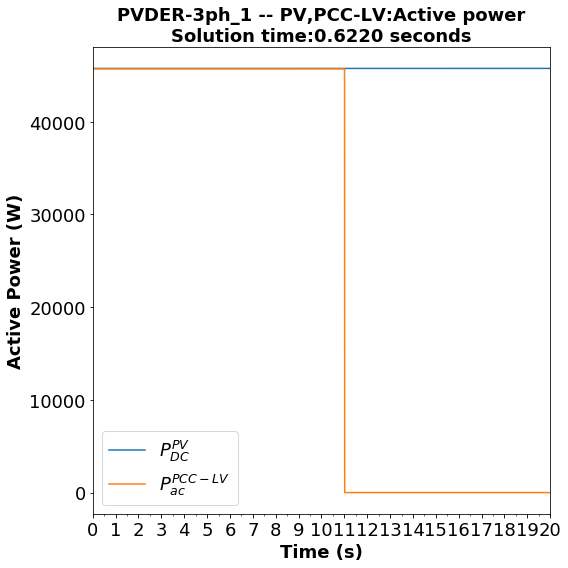

In [9]:
results1.PER_UNIT = False
results1.PLOT_TITLE = True
results1.font_size = 18
results1.plot_DER_simulation(plot_type='active_power_Ppv_Pac_PCC')#

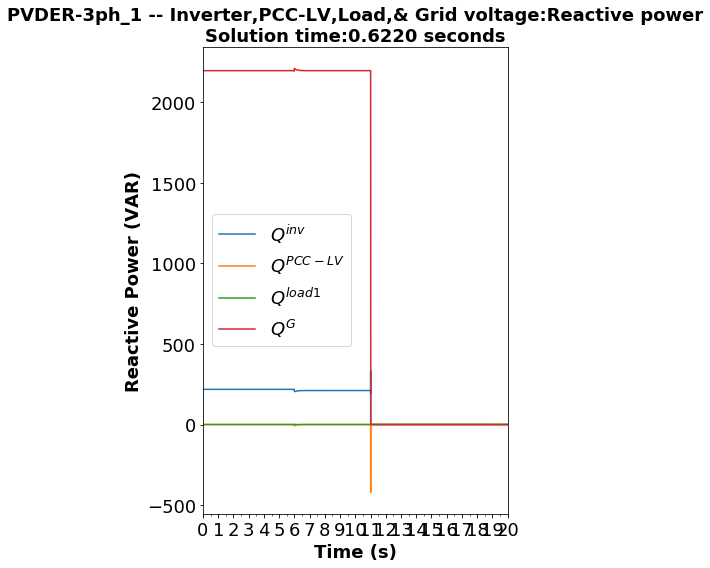

In [10]:
results1.plot_DER_simulation(plot_type='reactive_power')#_Q_PCC

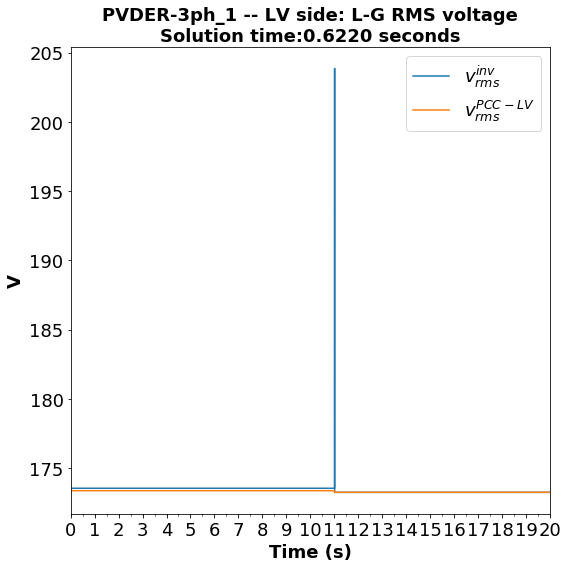

In [11]:
results1.plot_DER_simulation(plot_type='voltage_LV') #voltage_Vpcclv

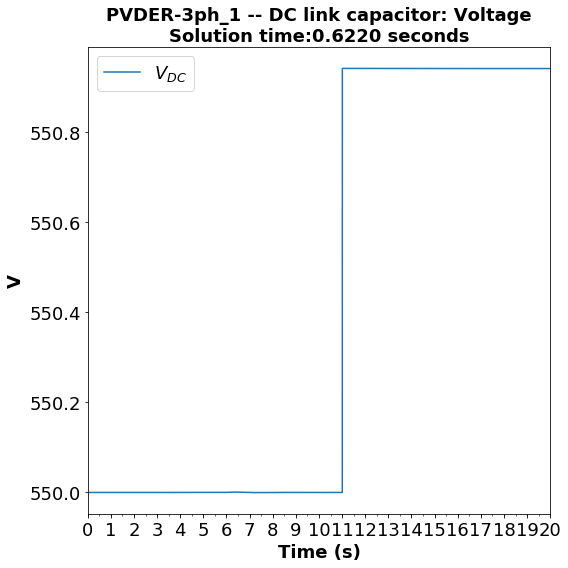

In [12]:
results1.plot_DER_simulation(plot_type='voltage_Vdc')

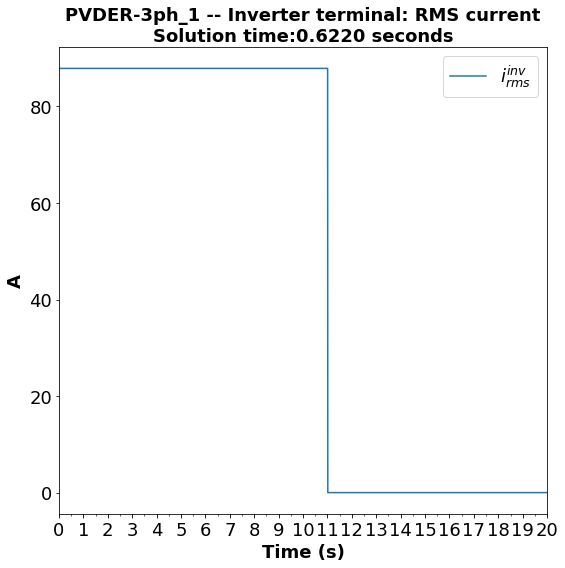

In [13]:
results1.plot_DER_simulation(plot_type='current')

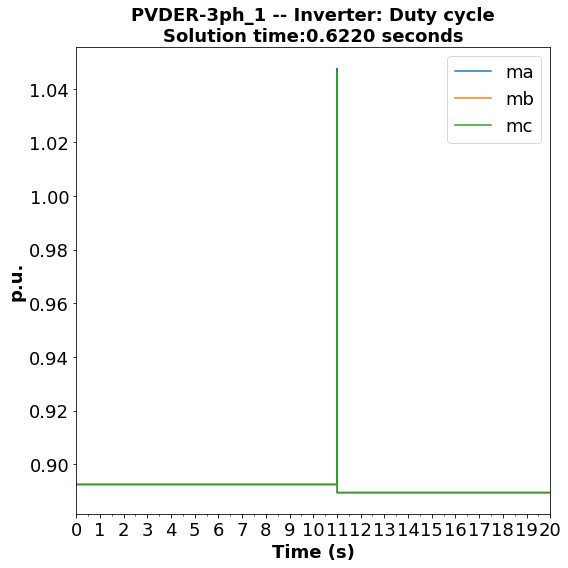

In [14]:
results1.plot_DER_simulation(plot_type='duty_cycle')

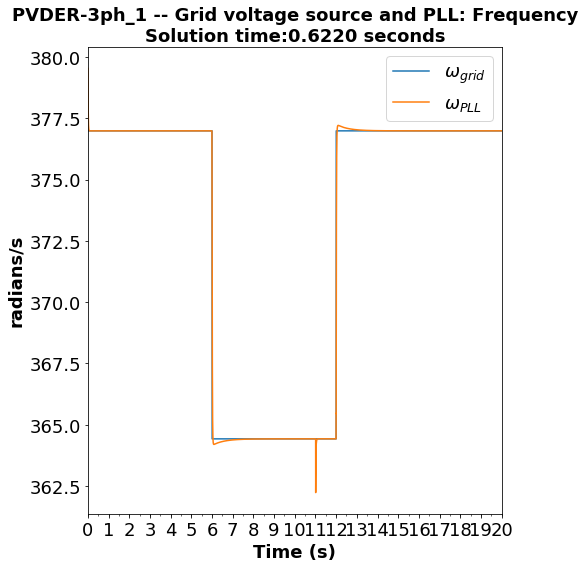

In [15]:
results1.plot_DER_simulation(plot_type='frequency')